The first cell is for downloading the file with the data from Github

In [13]:
import requests,io
r = requests.get("https://github.com/cdohl/bubble_detect/blob/main/Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V.AVI?raw=true")

with open("Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V.AVI", "wb") as f:
    f.write(io.BytesIO(r.content).getbuffer())

The next cell runs the code over the downloaded file

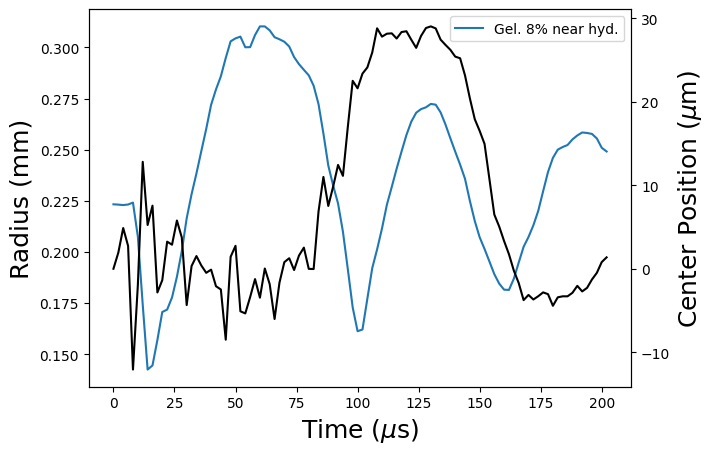

In [11]:
#libraries for image processing
from skimage import measure
from skimage.draw import circle_perimeter_aa
from skimage.color import rgb2gray
#libraries for plotting
import matplotlib.pyplot as plt
#libraries for matrix algebra
import numpy as np
#libraries for loading and storing images/movies
import imageio
#libraries for analysing polygons
from shapely.geometry import Polygon

#user values for the image processing
#image range
N = 102
N_start = 0
#threshold
my_thresh = 90
#crop range
x1,x2= 50,250
y1,y2= 120,250
#files to analyse are listed here 
compare=['Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V']
labels=['Gel. 8% near hyd.']
fr=[2.] #frame interval time in mu
nd=[-1]
dir_name='./'

#start the plotting
plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()

#initialize some variables, here the array for plots
ph=[]
n=0

for experiment in compare:
    
    #read images from the movies into a numpy array
    mo = imageio.mimread(dir_name+experiment+'.AVI')
    mov = np.asarray(([rgb2gray(mo[nn]) for nn in range(len(mo))]))*256
    
    #crop image
    mov = mov[:,y1:y2,x1:x2]
    
    #list of contours that are bubbbles
    kl=list()
    
    for i in range(N_start,N):

        #select one image
        img = mov[i]
        
        # calculate contour with a fixed threshold
        cont=measure.find_contours(img, my_thresh)
        
        # find the longest contour, this is likely the biggest bubble
        l=np.asarray([len(cont[nn]) for nn in range(len(cont))])
        y=cont[l.argmax()][:,0]
        x=cont[l.argmax()][:,1]
        
        # store contour as polygon
        k=Polygon(np.asarray([x,y]).T);
        
        # add circle on top of images for later verication
        rr, cc, val=circle_perimeter_aa(int(k.centroid.y), int(k.centroid.x),\
                                        int(np.sqrt(k.area/np.pi)))
        mov[i, rr, cc] = val * 255
        
        # save polygon
        kl.append(k)
        
    #generate time and radius date
    t_data=np.linspace(0,N-N_start-1,N-N_start)*fr[n]*1e-6
    R_data=(np.asarray([kl[nn].area for nn in range(len(kl))])/np.pi)**.5*1e-5
    
    #calculate displacement of centroid 
    centroids=[kl[nn].centroid for nn in range(len(kl))]
    dist=np.asarray([centroids[0].y-centroids[nn].y for nn in range(len(centroids))])*1e-5
    #just i case if date points should be omitted
    if nd[n] >0:
        nddist[nd[n]]=float('nan')
        R_data[nd[n]]=float('nan')
    
    #plot radius and position
    [h]=ax1.plot(t_data*1e6,R_data*1e3)
    ax2 = ax1.twinx() 
    ax2.plot(t_data*1e6,dist*1e6,'k')
    ax1.set_ylabel('Radius (mm)',fontsize=18)
    ax1.set_xlabel(r'Time ($\mu$s)',fontsize=18)
    ax2.set_ylabel(r'Center Position ($\mu$m)',fontsize=18)
    #and save each plots handler
    ph.append(h)
    n=n+1
    
ax1.legend(ph,labels);